In [1]:
# Add parent directory to Python path for module imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import matplotlib.pyplot as plt

from dataset_params import DatasetParams
from config import MAKE3D
import dataset_loader
import utils
import forward_model
import initialization
import coordinate_descent

/home/holly/Documents/depth-from-defocus/dfd/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


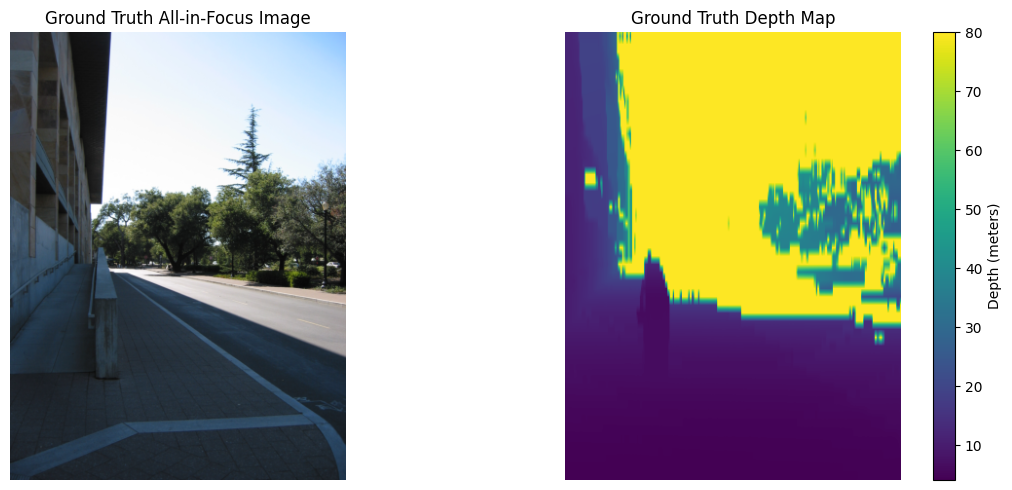

Image dimensions: 460 x 345
Adaptive kernel size: 17


In [2]:
# Initialize Make3D dataset configuration
dataset_params = DatasetParams.for_Make3D()
config = MAKE3D

# Load ground truth AIF and depth (sets f, D, ps on dataset_params)
gt_aif, gt_dpt = dataset_loader.load_single_sample_Make3D(
    img_name='img-060705-17.10.14-p-018t000.jpg',
    dataset_params=dataset_params,
    data_dir=config.data_dir
)

# Visualize ground truth AIF image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_aif / 255.)
plt.title('Ground Truth All-in-Focus Image')
plt.axis('off')

# Visualize ground truth depth map
plt.subplot(1, 2, 2)
plt.imshow(gt_dpt)
plt.title('Ground Truth Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print image dimensions
width, height, _ = gt_aif.shape
print(f'Image dimensions: {width} x {height}')

# Set adaptive kernel size based on image dimensions
max_kernel_size = utils.kernel_size_heuristic(width, height)
print(f'Adaptive kernel size: {max_kernel_size}')

In [3]:
# Validate dataset params and config
print("=== Dataset Params (Make3D) ===")
print(f"  f  (focal length):  {dataset_params.f}")
print(f"  D  (aperture dia):  {dataset_params.D}")
print(f"  Df (focus dists):   {dataset_params.Df}")
print(f"  ps (pixel size):    {dataset_params.ps}")
print(f"  min_Z:              {dataset_params.min_Z}")
print(f"  max_Z:              {dataset_params.max_Z}")
print(f"  thresh:             {dataset_params.thresh}")

print("\n=== Config (Make3DConfig) ===")
print(f"  data_dir:           {config.data_dir}")
print(f"  num_epochs:         {config.num_epochs}")
print(f"  num_z:              {config.num_z}")
print(f"  t_0:                {config.t_0}")
print(f"  alpha:              {config.alpha}")
print(f"  nesterov_first:     {config.nesterov_first}")
print(f"  use_windowed_mse:   {config.use_windowed_mse}")
print(f"  window_size:        {config.window_size}")
print(f"  aif_lambda:         {config.aif_lambda}")
print(f"  aif_sharpness:      {config.aif_sharpness_measure}")
print(f"  experiment_folder:  {config.experiment_folder}")

print("\n=== Runtime ===")
print(f"  max_kernel_size:    {max_kernel_size}")
print(f"  image shape (aif):  {gt_aif.shape}")
print(f"  depth shape:        {gt_dpt.shape}")
print(f"  depth range:        [{gt_dpt.min():.4f}, {gt_dpt.max():.4f}]")
print(f"  aif range:          [{gt_aif.min():.1f}, {gt_aif.max():.1f}]")

=== Dataset Params (Make3D) ===
  f  (focal length):  0.00709375
  D  (aperture dia):  0.002216796875
  Df (focus dists):   [ 1.  2.  4.  8. 16. 32. 64.]
  ps (pixel size):    1.5456521739130434e-07
  min_Z:              0.01
  max_Z:              80
  thresh:             0.5

=== Config (Make3DConfig) ===
  data_dir:           data
  num_epochs:         5
  num_z:              100
  t_0:                10
  alpha:              2.0
  nesterov_first:     False
  use_windowed_mse:   True
  window_size:        5
  aif_lambda:         0.05
  aif_sharpness:      sobel_grad
  experiment_folder:  experiments/make3d

=== Runtime ===
  max_kernel_size:    17
  image shape (aif):  (460, 345, 3)
  depth shape:        (460, 345)
  depth range:        [4.0865, 80.0000]
  aif range:          [7.1, 255.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.032234844..1.0000007].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.040807713..1.0000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03336455..1.0000006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02569986..1.0000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030004933..1.0000006].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027818687..1.0000004].


Defocus stack shape: (7, 460, 345, 3)
  - Number of focus levels: 7
  - Image dimensions: 460 x 345
  - Channels: 3


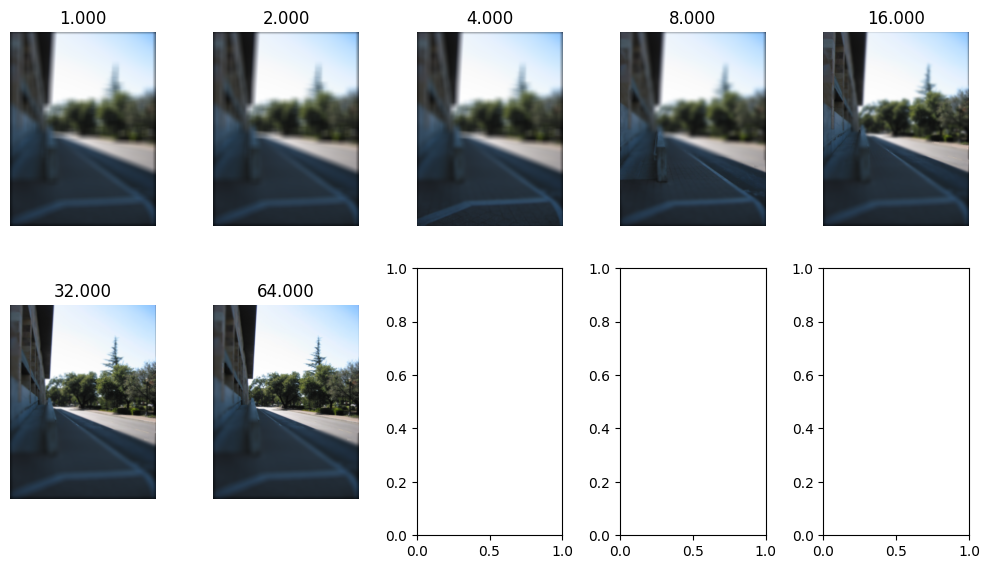

In [4]:
# Generate synthetically-blurred defocus stack
# This creates N images (one per focus distance in Df), each focused at a different depth
defocus_stack = forward_model.forward(gt_dpt, gt_aif, dataset_params, max_kernel_size)

print(f'Defocus stack shape: {defocus_stack.shape}')
print(f'  - Number of focus levels: {defocus_stack.shape[0]}')
print(f'  - Image dimensions: {defocus_stack.shape[1]} x {defocus_stack.shape[2]}')
print(f'  - Channels: {defocus_stack.shape[3]}')

# Visualize the defocus stack
utils.plot_single_stack(defocus_stack / 255., dataset_params.Df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.032234825..1.0000001].


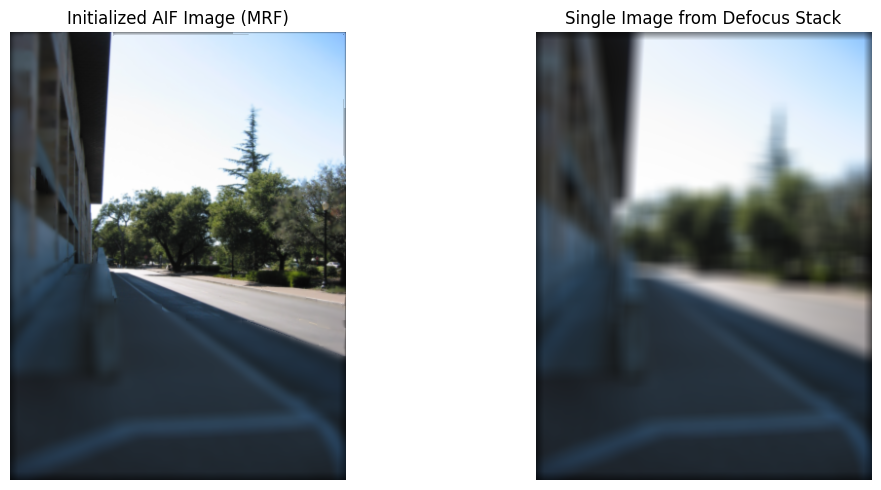

AIF initialization complete!


In [5]:
# Compute AIF initialization using MRF optimization
# - lmbda: controls tradeoff between data and smoothness terms
# - sharpness_measure: method for computing sharpness ('sobel_grad', 'laplacian', 'log')
aif_init = initialization.compute_aif_initialization(
    defocus_stack,
    lmbda=config.aif_lambda,
    sharpness_measure=config.aif_sharpness_measure
)

# Visualize initialized AIF and compare to one image from the stack
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(aif_init / 255.)
plt.title('Initialized AIF Image (MRF)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(defocus_stack[1] / 255.)
plt.title('Single Image from Defocus Stack')
plt.axis('off')

plt.tight_layout()
plt.show()

print('AIF initialization complete!')

Starting coordinate descent optimization...

Depth range: [ 0.01 - 80 ]
Created experiment folder: experiments/make3d/coord-descent_2026-02-13_23-46-45
Images in range [0-255]


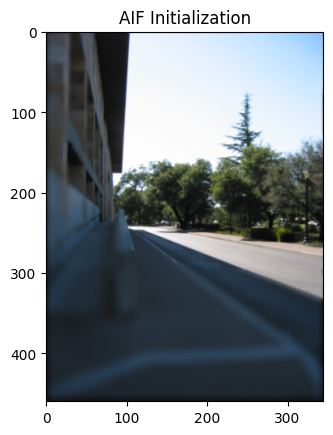

Iteration 0 



Grid search         :  78%|███████████████▌    | 78/100 [01:14<00:20,  1.05it/s]


KeyboardInterrupt: 

In [6]:
# Run coordinate descent optimization
print('Starting coordinate descent optimization...\n')

dpt, aif, _, _ = coordinate_descent.coordinate_descent(
    defocus_stack,
    # Camera/scene params (focal length, aperture, focus distances, depth range, etc.)
    dataset_params,
    # Max blur kernel size (controls forward model resolution)
    max_kernel_size,
    # Optimization parameters
    num_epochs=config.num_epochs,
    num_Z=config.num_z,
    T_0=config.t_0,
    alpha=config.alpha,
    nesterov_first=config.nesterov_first,
    # Initialization
    aif_init=aif_init,
    # Windowed MSE (used for outdoor scenes with large depth range)
    windowed_mse=config.use_windowed_mse,
    window_size=config.window_size,
    # Visualization
    experiment_folder=config.experiment_folder,
    show_plots=True,
    save_plots=config.save_plots,
    verbose=config.verbose
)

print('\nOptimization complete!')

In [ ]:
# Visualize reconstructed AIF image and depth map
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(aif / 255.)
plt.title('Reconstructed All-in-Focus Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.title('Reconstructed Depth Map')
plt.colorbar(label='Depth (meters)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Compute accuracy metrics
rms = utils.compute_RMS(dpt, gt_dpt)
rel = utils.compute_AbsRel(dpt, gt_dpt)
accuracy_metrics = utils.compute_accuracy_metrics(dpt, gt_dpt)

# Display results
print('=' * 50)
print('ACCURACY METRICS')
print('=' * 50)
print(f'RMS Error:           {rms:.6f}')
print(f'Relative Error:      {rel:.6f}')
print(f'delta < 1.25:        {accuracy_metrics["delta1"]:.4f}')
print(f'delta < 1.25^2:      {accuracy_metrics["delta2"]:.4f}')
print(f'delta < 1.25^3:      {accuracy_metrics["delta3"]:.4f}')
print('=' * 50)

# Side-by-side depth comparison
utils.plot_compare_greyscale(dpt, gt_dpt, vmin=dataset_params.min_Z, vmax=dataset_params.max_Z)